In [67]:
import os
working_directory = os.getcwd()
print(working_directory)
import category_encoders as ce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statistics

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from fancyimpute import KNN,SoftImpute
from xgboost import plot_importance
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneOut
from time import time
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

/Users/ghxclaire/A_Live Projects


In [7]:
df = pd.read_csv('patient_waiting_time.csv')

In [8]:
df.head(5)

,ID,Facility,Dept,Appt_DateTime,ChkIn_Time,PhySeenTime,Include,ChkIn_NurSeen,NurSeen_PhySeen,WaitingTime,...,ChkIn_Time_hour,PhySeenTime_month,PhySeenTime_week,PhySeenTime_day,PhySeenTime_dayofweek,PhySeenTime_hour,chkIn_after_appointment,chkin_late_minutes,phy_late_minutes,waitingtime_groups
0,30534757,Facility_1,Surg,2019-01-02 08:20:00,2019-01-02 08:06:36,2019-01-02 08:17:19,Yes,4,7,11,...,8,1,1,1,2,8,False,-13.400000,-2.683333,0 to 15 Mins
1,30529244,Facility_1,Ortho,2019-01-02 08:15:00,2019-01-02 08:13:23,2019-01-02 08:37:05,Yes,0,24,24,...,8,1,1,1,2,8,False,-1.616667,22.083333,15 to 30 Mins
2,29157451,Facility_1,Medical,2019-01-02 08:35:00,2019-01-02 08:28:52,2019-01-02 08:37:21,Yes,7,2,9,...,8,1,1,1,2,8,False,-6.133333,2.350000,0 to 15 Mins
3,29749311,Facility_1,Ortho,2019-01-02 08:25:00,2019-01-02 08:22:54,2019-01-02 08:41:09,Yes,2,17,19,...,8,1,1,1,2,8,False,-2.100000,16.150000,15 to 30 Mins
4,30384249,Facility_1,Opthal,2019-01-02 08:40:00,2019-01-02 08:42:39,2019-01-02 08:46:51,Yes,1,3,4,...,8,1,1,1,2,8,True,2.650000,0.000000,0 to 15 Mins


# Handling categorical variables

## One-hot encoding: chkIn_after_appointment

In [9]:
# Function of converting into number: 
def convert_into_num(cat_cols):
    for c in cat_cols:
        df[c]=pd.factorize(df[c])[0]
    return df[c]

In [10]:
cat_cols =['chkIn_after_appointment']
convert_into_num(cat_cols)

0        0
1        0
2        0
3        0
4        1
        ..
28148    0
28149    1
28150    0
28151    1
28152    1
Name: chkIn_after_appointment, Length: 28153, dtype: int64

## Frequency encoding: 'Facility','Dept','Phy_Name'

In [11]:
def frequency_encoding(cols):
    for c in cols:
        c_dict = df[c].value_counts()/len(df)
        df[c]=df[c].map(c_dict)
    return df[c]

In [12]:
cols = ['Facility','Dept','Phy_Name']
frequency_encoding(cols)

0        0.002700
1        0.020921
2        0.015167
3        0.023301
4        0.034774
           ...   
28148    0.011935
28149    0.018613
28150    0.053493
28151    0.034774
28152    0.008667
Name: Phy_Name, Length: 28153, dtype: float64

## Ordinal Encoding: Target Variable 'Grouping'

In [13]:
c = df['waitingtime_groups'].value_counts(dropna=False)
p = df['waitingtime_groups'].value_counts(dropna=False, normalize=True).mul(100).round(3).astype(str) + '%'
pd.concat([c,p], axis=1, keys=['Counts', 'Percentage'])

,Counts,Percentage
0 to 15 Mins,10181,36.163%
15 to 30 Mins,7808,27.734%
30 to 45 Mins,4330,15.38%
>60 Mins,3305,11.739%
45 to 60 Mins,2529,8.983%


<Axes: >

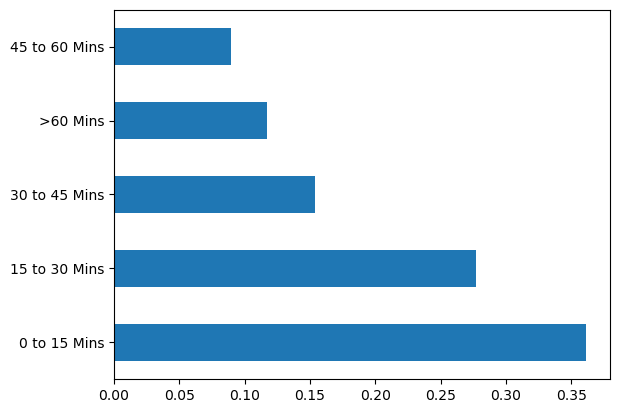

In [14]:
df['waitingtime_groups'].value_counts(normalize=True)[:10].plot.barh()

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['waitingtime_groups']=le.fit_transform(df['waitingtime_groups'])
df['waitingtime_groups'].value_counts()

0    10181
1     7808
2     4330
4     3305
3     2529
Name: waitingtime_groups, dtype: int64

## Get features

In [16]:
# Function of dropping columns:
def drop_col(df,col_list):
    for col in col_list:
        if col not in df.columns:
            raise KeyError(f"{col} does not exit in dataframe")
        else: 
             df_drop = df.drop(col_list,axis=1)
    return(df_drop)

In [17]:
# First, we define the features and target variables to use in the models. 
# Drop meaningless variables 'ID' & 'Include'
# Drop features that are calculated from WaitingTime: 
# 'ChkIn_NurSeen','NurSeen_PhySeen','ChkIn_ChkOut'
# Drop datetime features that are repetitive: datetime variables 

drop_col_list =(['ID','Include','ChkIn_NurSeen','NurSeen_PhySeen','ChkIn_ChkOut',
                'Appt_DateTime','ChkIn_Time','PhySeenTime','ChkIn_Time_month',
                 'ChkIn_Time_week','ChkIn_Time_day','ChkIn_Time_dayofweek','ChkIn_Time_hour',
                 'PhySeenTime_month','PhySeenTime_week','PhySeenTime_day',
                'PhySeenTime_dayofweek','PhySeenTime_hour','Appt_Date'])

dropped_list = drop_col(df,drop_col_list)

In [18]:
features_list= drop_col(dropped_list,['waitingtime_groups','WaitingTime'])

In [19]:
# Get dummy variables: 
# df_list=pd.get_dummies(df_list,drop_first=True)

## Check the correlation among features

<Axes: >

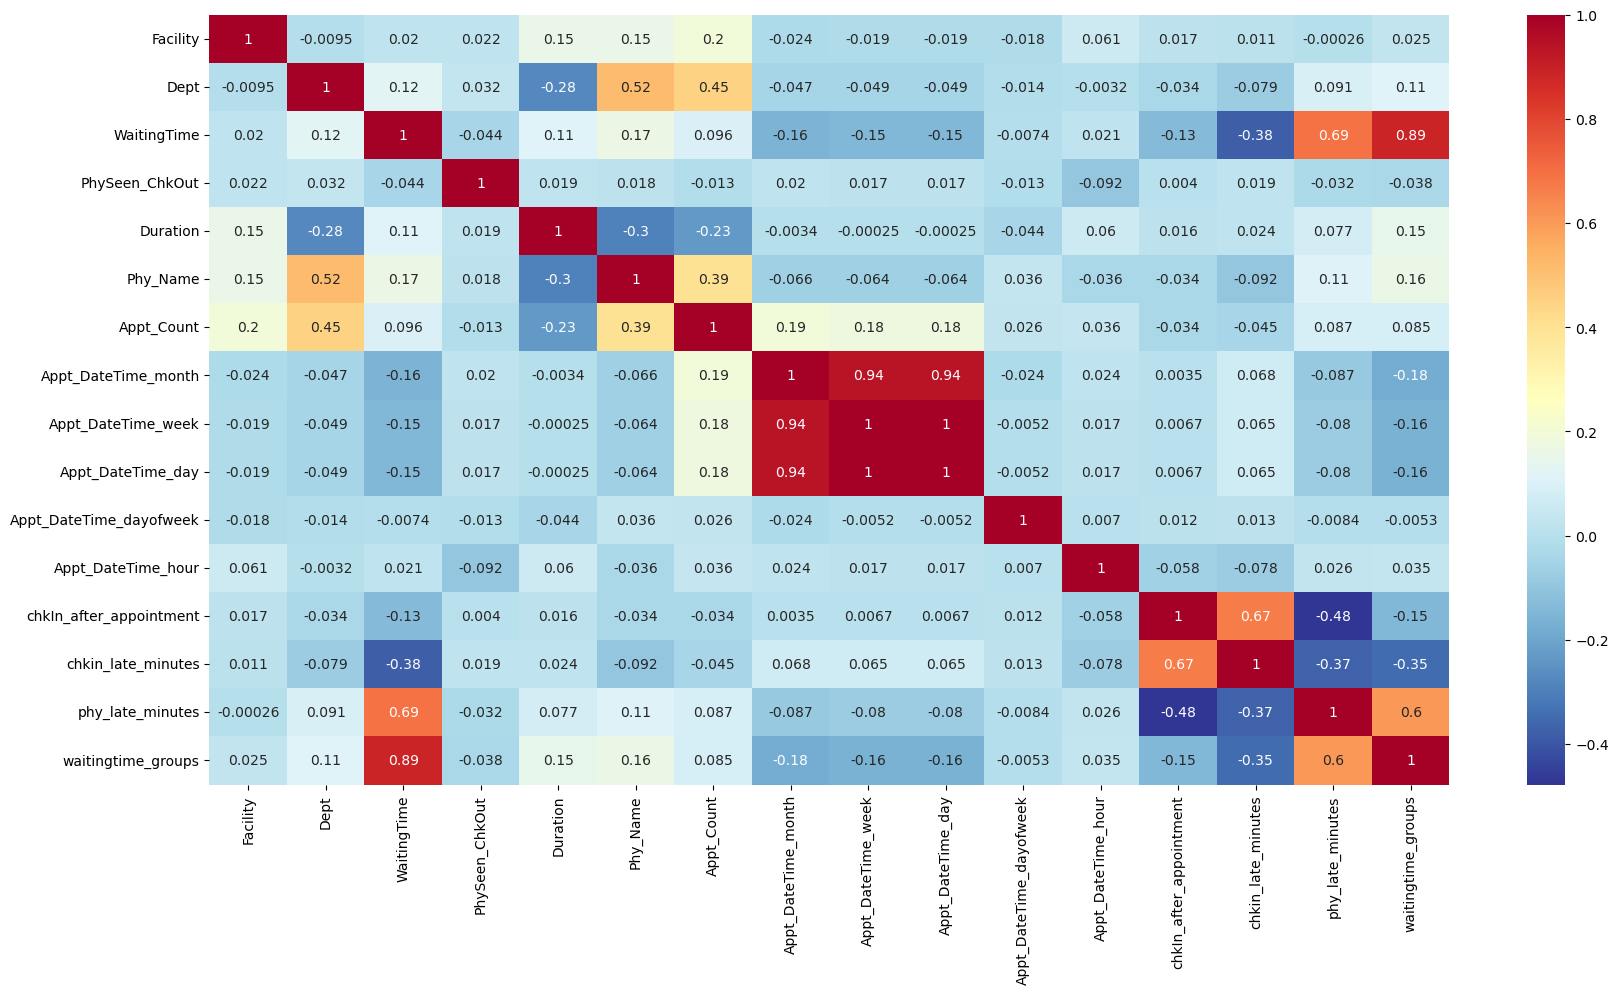

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20,10))
corr_matrix = dropped_list.corr(method = 'pearson') # 'pearson' is default
corr_matrix

sns.heatmap(corr_matrix,annot=True,cmap='RdYlBu_r')

In [21]:
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j])>0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print("Correlated Features : ", correlated_features)

Correlated Features :  {'PhySeenTime_day', 'PhySeenTime_dayofweek', 'ChkIn_Time_dayofweek', 'Appt_DateTime_day', 'PhySeenTime_month', 'PhySeenTime_hour', 'Appt_DateTime_week', 'ChkIn_Time_hour', 'ChkIn_Time_month', 'waitingtime_groups', 'ChkIn_Time_day', 'ChkIn_Time_week', 'WaitingTime', 'Appt_DateTime_month', 'PhySeenTime_week'}


/var/folders/43/0z_4kqns5c79zn8qb4t23rd40000gn/T/ipykernel_99742/3954097883.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


In [22]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.65
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

to_drop

['Appt_DateTime_week', 'Appt_DateTime_day', 'waitingtime_groups']

In [23]:
# Drop features that are heavily correlated to each other
features_list.drop(['Appt_DateTime_week','Appt_DateTime_day'],inplace=True,axis=1)

/Users/ghxclaire/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ghxclaire/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ghxclaire/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


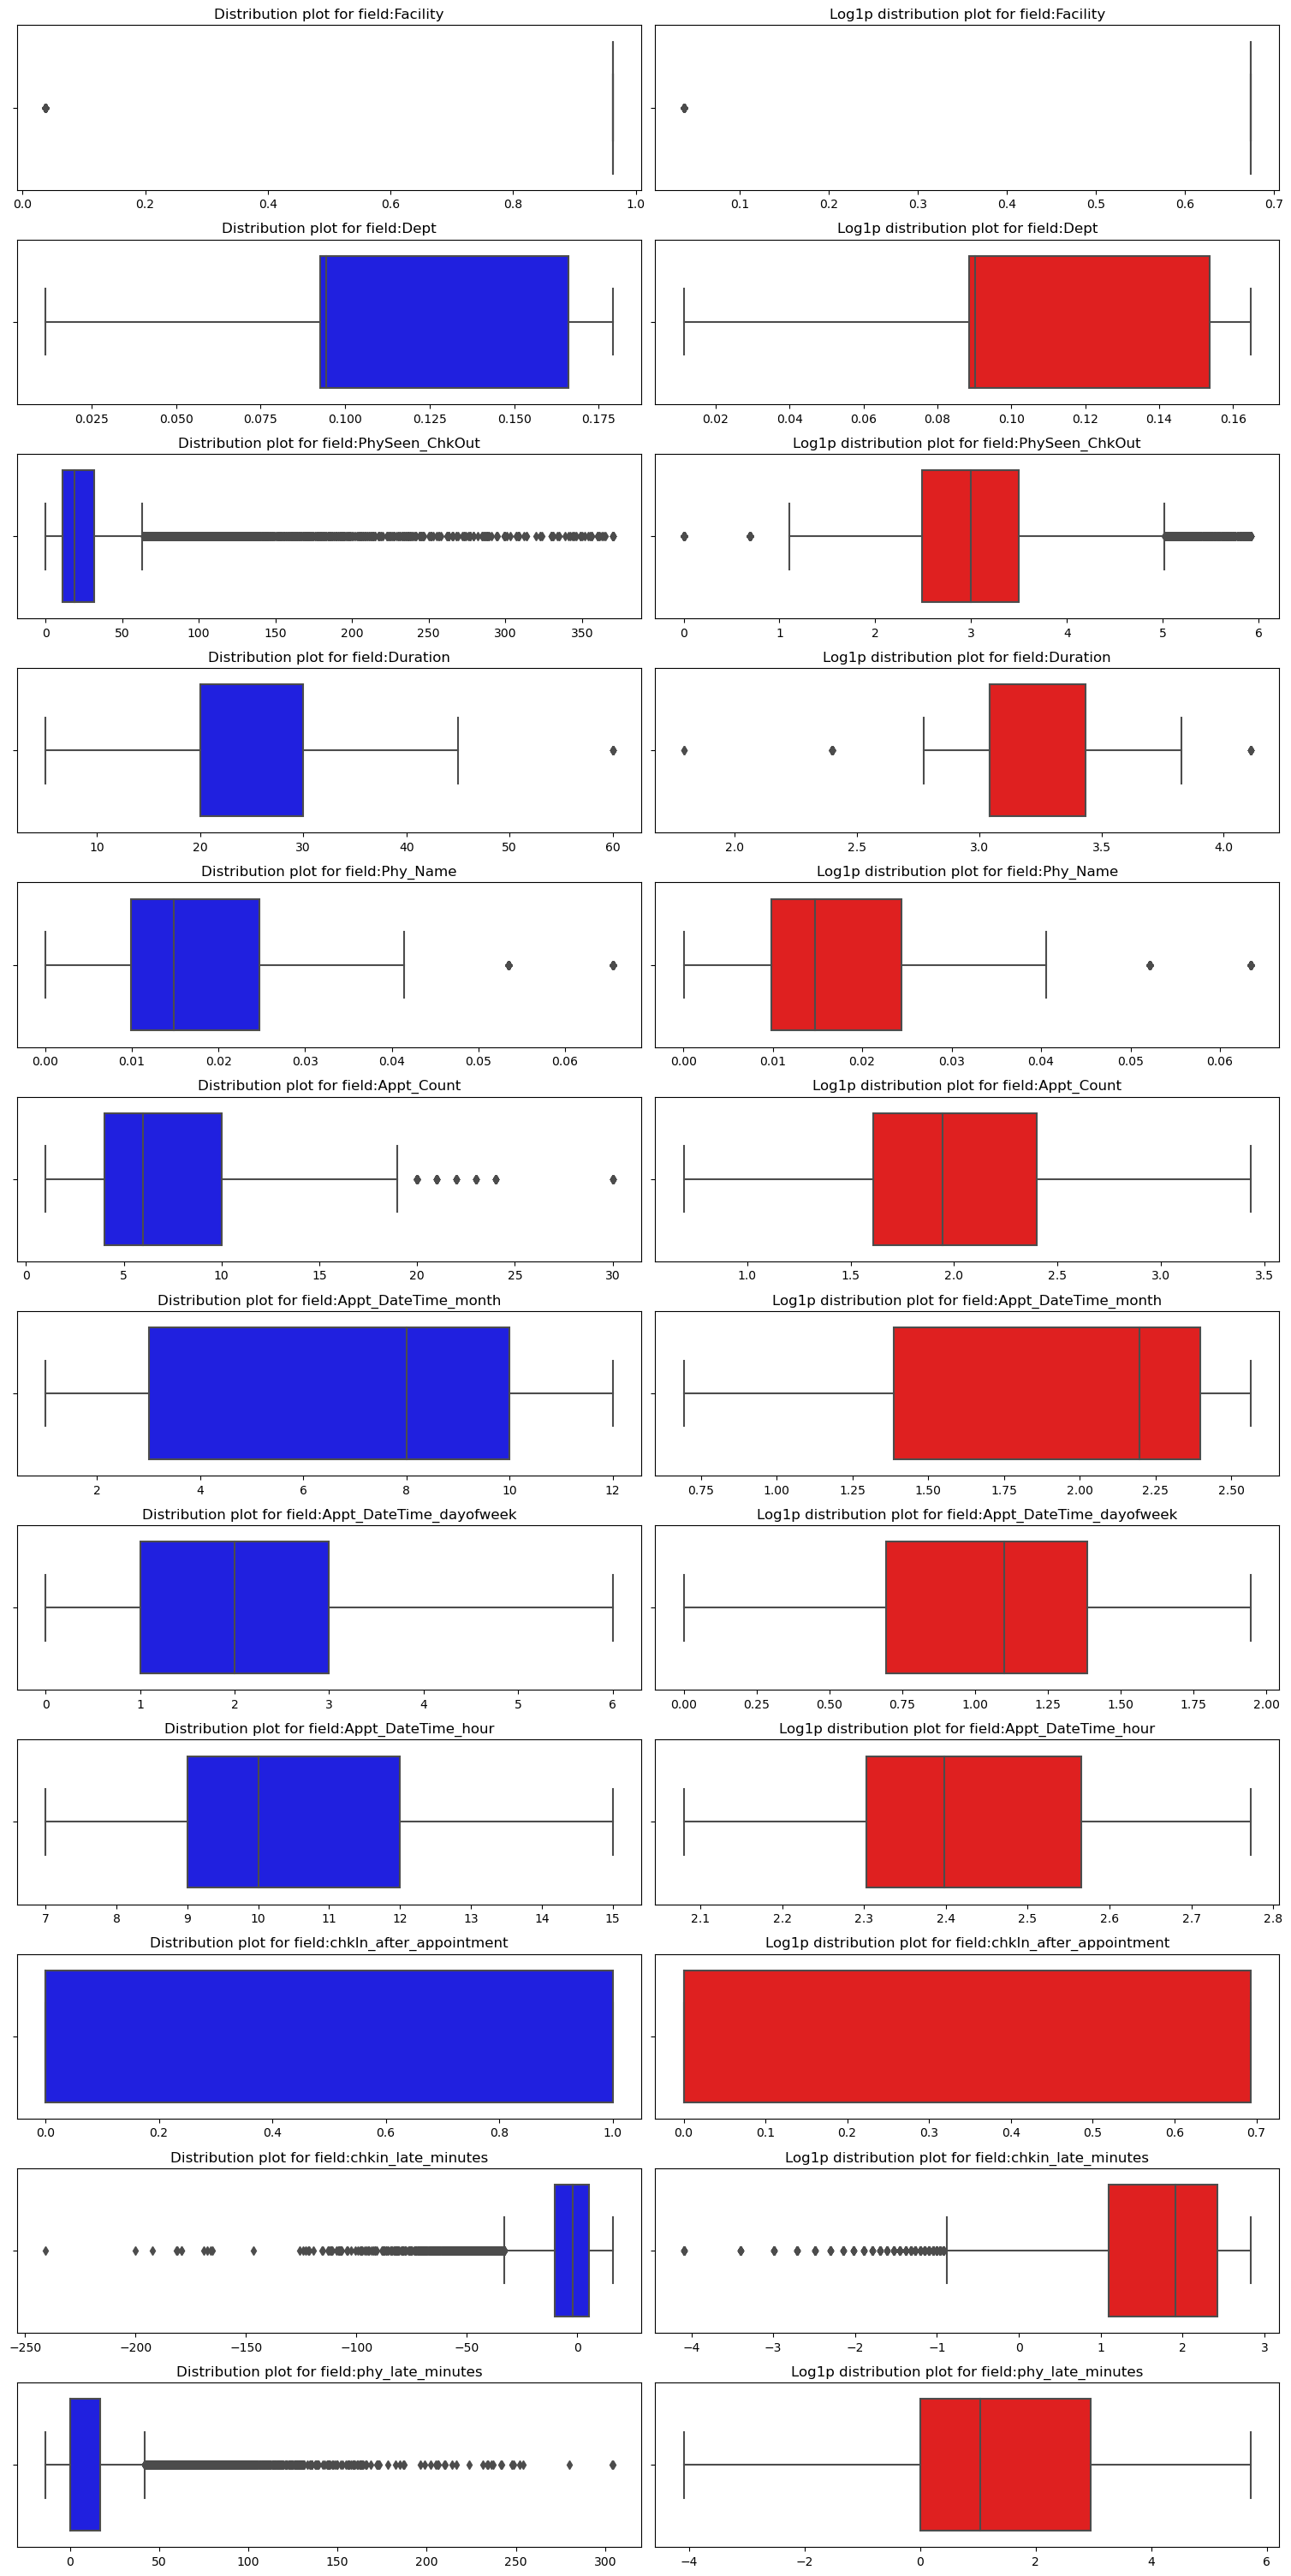

In [21]:
plt.figure(figsize=(15, 30))

cols = features_list.select_dtypes(include='number').columns
num_cols = len(cols)

for i, c in enumerate(cols):
    plt.subplot(num_cols,2,i*2+1)
    sns.boxplot(df[c], color='blue')
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    plt.subplot(num_cols,2,i*2+2)
    sns.boxplot(df[c].apply('log1p'), color='red')
    plt.title('Log1p distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [223]:
# features_list['PhySeen_ChkOut'] = np.log1p(features_list['PhySeen_ChkOut'] )
# features_list['phy_late_minutes'] = np.log1p(features_list['phy_late_minutes'] )
# features_list['chkin_late_minutes'] = np.log1p(features_list['chkin_late_minutes'] )
# features_list['Appt_DateTime_dayofweek'] = np.log1p(features_list['Appt_DateTime_dayofweek'] )
# features_list['Appt_Count'] = np.log1p(features_list['Appt_Count'] )

## Scale the data

In [112]:
# df_LC=pd.get_dummies(features_list,drop_first=True)

In [24]:
x_scaled = preprocessing.scale(features_list)
print(x_scaled)
print('  ')
print(x_scaled.shape)

[[ 0.197411   -0.87531031 -0.54462568 ... -0.87178122 -0.66743632
  -0.67072802]
 [ 0.197411    0.99999901  0.11411864 ... -0.87178122  0.1650392
   0.46044791]
 [ 0.197411    0.39649924 -0.08636877 ... -0.87178122 -0.15405679
  -0.44083897]
 ...
 [ 0.197411    1.25575468 -0.08636877 ... -0.87178122 -0.22941526
  -0.30305778]
 [ 0.197411   -0.40839941 -0.45870251 ...  1.14707678  0.86681488
  -0.54817127]
 [ 0.197411   -0.44184974 -0.34413828 ...  1.14707678  1.36724217
  -0.54817127]]
  
(28153, 12)


In [25]:
waitingtime =  df['WaitingTime']

In [26]:
y_waitingtime_scaled = preprocessing.scale(df['WaitingTime'])
print(y_waitingtime_scaled)
print('  ')
print(y_waitingtime_scaled.shape)

[-0.68368511 -0.21877136 -0.75521031 ... -0.61215992 -0.71944771
 -0.57639733]
  
(28153,)


In [27]:
y_grouping_scaled = preprocessing.scale(df['waitingtime_groups'])
print(y_grouping_scaled)
print('  ')
print(y_waitingtime_scaled.shape)

[-0.97972629 -0.23976025 -0.97972629 ... -0.97972629 -0.97972629
 -0.97972629]
  
(28153,)


# Regression Model (waiting time as the dependent variable)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#separating independent and dependent variable
X = x_scaled
y = y_waitingtime_scaled

#splitting dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state=100)


### Multi-linear regression

In [38]:
mlr = LinearRegression()
model=mlr.fit(X_train, y_train)

print(model.intercept_, model.coef_, model.score(X, y))

-0.003891985237219937 [-0.018505    0.00411276 -0.01701806  0.0944229   0.07217303  0.03361861
 -0.0662012  -0.00181635 -0.00421003  0.52190033 -0.44068511  0.75576938] 0.6613361859996589


### Ordinary Least Squares

In [39]:
import statsmodels.api as sm

#add constant to predictor variables
X = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.659
Model:                            OLS   Adj. R-squared (uncentered):              0.659
Method:                 Least Squares   F-statistic:                              3177.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):                        0.00
Time:                        16:46:24   Log-Likelihood:                         -17166.
No. Observations:               19707   AIC:                                  3.436e+04
Df Residuals:                   19695   BIC:                                  3.445e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [291]:
y_predict = model.predict(x_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predict))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_predict))

Mean squared error: 0.35
[[1.         0.81586948]
 [0.81586948 1.        ]]
Coefficient of determination: 0.67


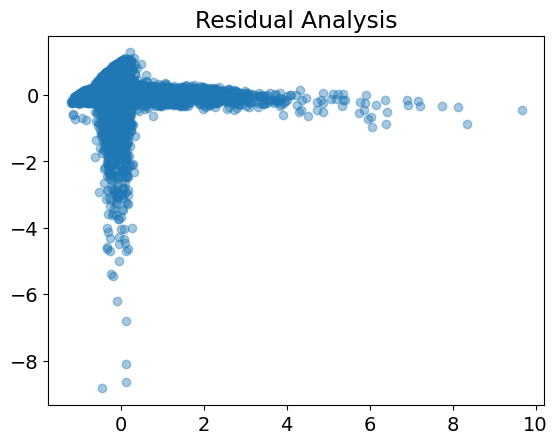

In [122]:
residuals = y_predict - y_test
 
plt.scatter(y_predict, residuals, alpha=0.4)
plt.title('Residual Analysis')
 
plt.show()

In [30]:
from sklearn.linear_model import Ridge

In [53]:
# function for performing grid search
def gridSearchReport( estimator, X, y, pg, cv=LeaveOneOut(), rs=42):
    """
    Performs the grid search and cross validation for the given regressor.
    Params:
        estimator:  the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        pg: dict, parameters' grid
        cv: int, cross-validation generator or an iterable, cross validation folds
        rs: int, training-test split random state
    """    

    t0 = time()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=rs) # train test split for normal regression models
 

    est_cv = GridSearchCV(
        estimator, 
        param_grid=pg, 
        scoring="neg_mean_squared_error", 
        n_jobs=-1, 
        cv=cv
       )
    
    est_cv.fit(X_train, y_train)
    
    print("Best parameters:", est_cv.best_params_) # best parameters
    print("Best CV score:", abs(est_cv.best_score_)) # cross validation score
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) # predictions on train and test data
    print("MSE, R2 train:", mean_squared_error(y_train, y_train_pred),  # evaluation metrics
          ", ", r2_score(y_train, y_train_pred) )
    print("MSE, R2 test:", mean_squared_error(y_test, y_test_pred),
          ", ", r2_score(y_test, y_test_pred) )
    
    t = round(time()-t0, 2)
    print("Elapsed time:", t, "s ,", round(t/60, 2), "min")
    
    return est_cv

In [56]:
def plotResidue(estimator, X, y, rs=42):
    """
    Plots the fit residuals (price - predicted_price) vs. "surface" variable.
    Params:
        estimator: GridSearchCV, the regressor
        X: Pandas dataframe, feature data
        y: Pandas series, target
        rs: int, random state
    """    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=rs) # train tets split

    residue_train = y_train-estimator.predict(X_train) # make predictions
    residue_test = y_test-estimator.predict(X_test)                                                     
                                                          
    fig, axes = plt.subplots(figsize=(18,10)) 
    axes[0].scatter( X_train["surface"], residue_train, label="train" )
    axes[0].scatter( X_test["surface"], residue_test, label="test" )
    axes[0].plot( [-2.3, 4.5], [0,0], "black" )
    axes[0].set_xlabel("Scaled surface")
    axes[0].set_ylabel("Fit residulas")
    axes[0].legend()
    
    axes[1].hist(residue_test, bins=25)
    axes[1].set_xlabel("Fit residual for test set")
    axes[1].set_ylabel("Count")

    #plt.show()
    plt.savefig(OUTPUT_DIR + "plot_residual.png")
    print("mean residuals:", round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))
    

In [43]:
#Function to build linear regression model
def reg_model(X_train, X_test, y_train, y_test, X,y,rs):
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        score = r2_score(y_train, lr.predict(X_train)),\
                r2_score(y_test, lr.predict(X_test)) # check for the r2 score on train and test data
        return score

In [44]:
reg_model(X_train, X_test, y_train, y_test, X,y,42)

(0.659359013911921, 0.6654403755055482)

In [63]:
#Function to build rideg regression model
def ridge_model(X,y,rs):
    alphas = np.logspace(-3,3,10)# define the parameters for ridge regression model and check for the grid search 
    pg = {"alpha":alphas}
    ridge = Ridge()#define a ridege model
    ridg_cv = gridSearchReport(ridge, X, y, pg, rs=rs)
    return ridg_cv

In [64]:
ridge_model(X,y,42)

Best parameters: {'alpha': 0.001}
Best CV score: 0.330880085062476
MSE, R2 train: 0.33048242555354046 ,  0.6689044876352099
MSE, R2 test: 0.35786894947145065 ,  0.6435325198801958
Elapsed time: 124.54 s , 2.08 min


GridSearchCV(cv=LeaveOneOut(), estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [69]:
#Function to build lasso regression model
def lasso_model(X,y,rs): 
    lasso = Lasso()
    alphas = np.logspace(-3,3,100)
    pg = {"alpha":alphas} # define the parameters and plot the lasso regression model
    lasso_cv = gridSearchReport( lasso, X, y, pg, rs=rs )
    return lasso_cv

In [70]:
lasso_model(X,y,42)

Best parameters: {'alpha': 0.001}
Best CV score: 0.33086146957674817
MSE, R2 train: 0.3304990623963706 ,  0.6688878199289265
MSE, R2 test: 0.3579524972530848 ,  0.6434492992844086
Elapsed time: 1178.08 s , 19.63 min


GridSearchCV(cv=LeaveOneOut(), estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

# Classification Models 

In [75]:
x = x_scaled
y = df['waitingtime_groups']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, test_size = 0.3, random_state=100)

## Running models

In [76]:
def classify(estimator, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    estimator.fit(x, y)
    #Predicting the probabilities of the Tet data
    y2 = estimator.predict_proba(X_test)
    y1 = estimator.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test,y2,multi_class='ovo'))
    print('matthews_corrcoef',metrics.matthews_corrcoef(y_test, y1)),
    print("F-metric: ", metrics.f1_score(y_test, y1,average='macro'))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(estimator, x, y))
        
    return estimator, y1, y2[:, 1]

In [77]:
#Function to find which features are more important than others through model
import operator
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(features_list.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1),reverse=True)
    
    return sorted_x

In [78]:
def run_models(X_train,y_train,X_test,y_test,model_type='imbalanced'):
    clfs = {'KNNClassifier':KNeighborsClassifier(n_neighbors=3),
           'LogisticRegression':LogisticRegression(),
            'DecisionTreeClassifier':DecisionTreeClassifier(),
            'SVM': SVC(kernel='rbf', C=1.0, probability=True),
            'NaiveBayes': GaussianNB(),
            'GradientBoosting': 
            GradientBoostingClassifier(max_depth=6, n_estimators=100, max_features=0.3),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=4),
            'XGBClassifier': XGBClassifier()
           }
    metrics_cols =['model_name','model_type','roc_auc_score','matthews_corrcoef','precision_score','recall_score','f1_score']
    models_report = pd.DataFrame(columns = metrics_cols)
    conf_matrix = dict()
    
    for clf,clf_name in zip(clfs.values(),clfs.keys()):
        if clf == "KNNClassifier":
            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            scaler.fit(X_test)
            X_test = scaler.transform(X_test)
        
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        y_score= clf.predict_proba(X_test)
        
        tmp = pd.Series({
            'model_name':clf_name,
            'model_type':model_type,
            'roc_auc_score' : metrics.roc_auc_score(y_test, y_score,multi_class='ovo'),
            'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
            'precision_score':metrics.precision_score(y_test,y_pred,average='macro'),
            'recall_score':metrics.recall_score(y_test,y_pred,average='macro'),
            'f1_score':metrics.f1_score(y_test,y_pred,average='macro')})
        
        models_report = models_report.append(tmp,ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False) 
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1], drop_intermediate = False,pos_label = 1)
        plt.figure(1, figsize=(10,10))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format('imbalanced'))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
        plt.plot([0,1],[0,1], color = 'black')
             
    return models_report,conf_matrix

In [82]:
from sklearn.svm import SVC
model = SVC()
from sklearn.naive_bayes import GaussianNB

/var/folders/43/0z_4kqns5c79zn8qb4t23rd40000gn/T/ipykernel_99742/582610651.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_report = models_report.append(tmp,ignore_index = True)
/var/folders/43/0z_4kqns5c79zn8qb4t23rd40000gn/T/ipykernel_99742/582610651.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_report = models_report.append(tmp,ignore_index = True)
/var/folders/43/0z_4kqns5c79zn8qb4t23rd40000gn/T/ipykernel_99742/582610651.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_report = models_report.append(tmp,ignore_index = True)
/var/folders/43/0z_4kqns5c79zn8qb4t23rd40000gn/T/ipykernel_99742/582610651.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pan

,model_name,model_type,roc_auc_score,matthews_corrcoef,precision_score,recall_score,f1_score
0,KNNClassifier,imbalanced,0.770059,0.377433,0.545609,0.481051,0.501439
1,LogisticRegression,imbalanced,0.863657,0.523302,0.704499,0.605593,0.634288
2,DecisionTreeClassifier,imbalanced,0.816166,0.616654,0.699866,0.705866,0.702719
3,SVM,imbalanced,0.902242,0.641146,0.824335,0.685931,0.731985
4,NaiveBayes,imbalanced,0.760563,0.415544,0.578223,0.498791,0.512701
5,GradientBoosting,imbalanced,0.931471,0.655800,0.787930,0.703763,0.734047
6,RandomForestClassifier,imbalanced,0.843181,0.544061,0.662055,0.615290,0.633491
7,XGBClassifier,imbalanced,0.941702,0.668662,0.788782,0.724456,0.749032


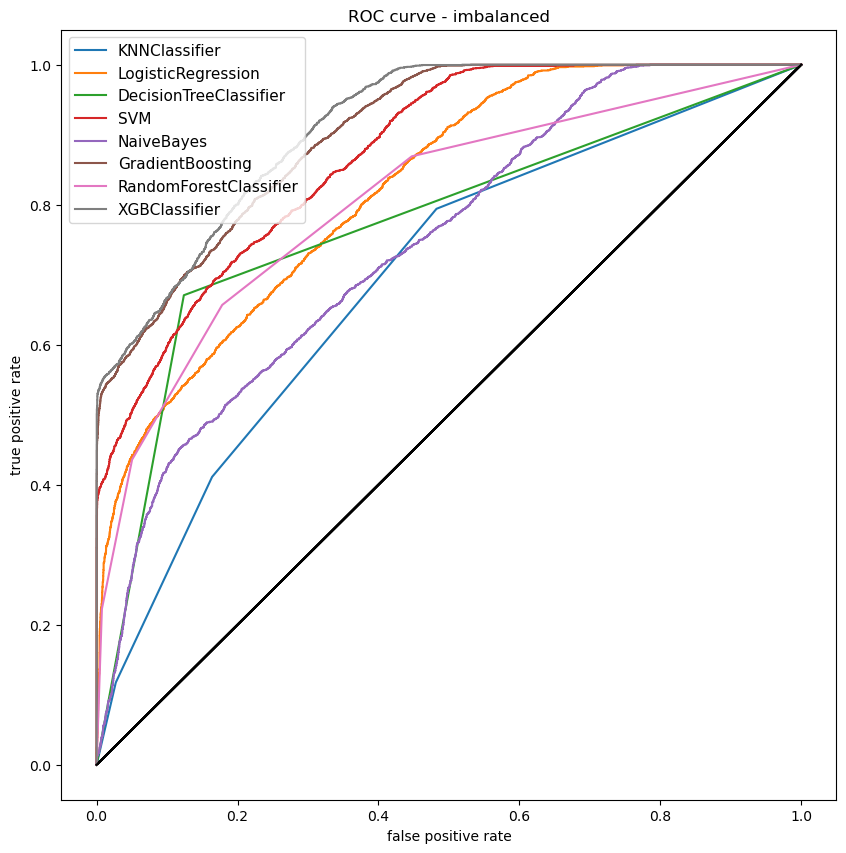

In [83]:
models,conf_matrix = run_models(x_train,y_train,x_test,y_test,model_type='imbalanced')
models

## Feature Importance 

### Feature importance of Gradient Boosting

Accuracy:  0.7422448496329623
Area under the ROC curve:  0.9291254622386539
matthews_corrcoef 0.6534077499635721
F-metric:  0.7392295228696039
 
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.91      0.80      2989
           1       0.65      0.68      0.66      2308
           2       0.94      0.57      0.71      1341
           3       0.91      0.61      0.73       785
           4       0.90      0.72      0.80      1023

    accuracy                           0.74      8446
   macro avg       0.82      0.70      0.74      8446
weighted avg       0.77      0.74      0.74      8446

 
Evaluation by cross-validation:
[0.75367834 0.73744292 0.75792946 0.74524232 0.75564578]


Text(0.5, 1.0, 'Feature Importance')

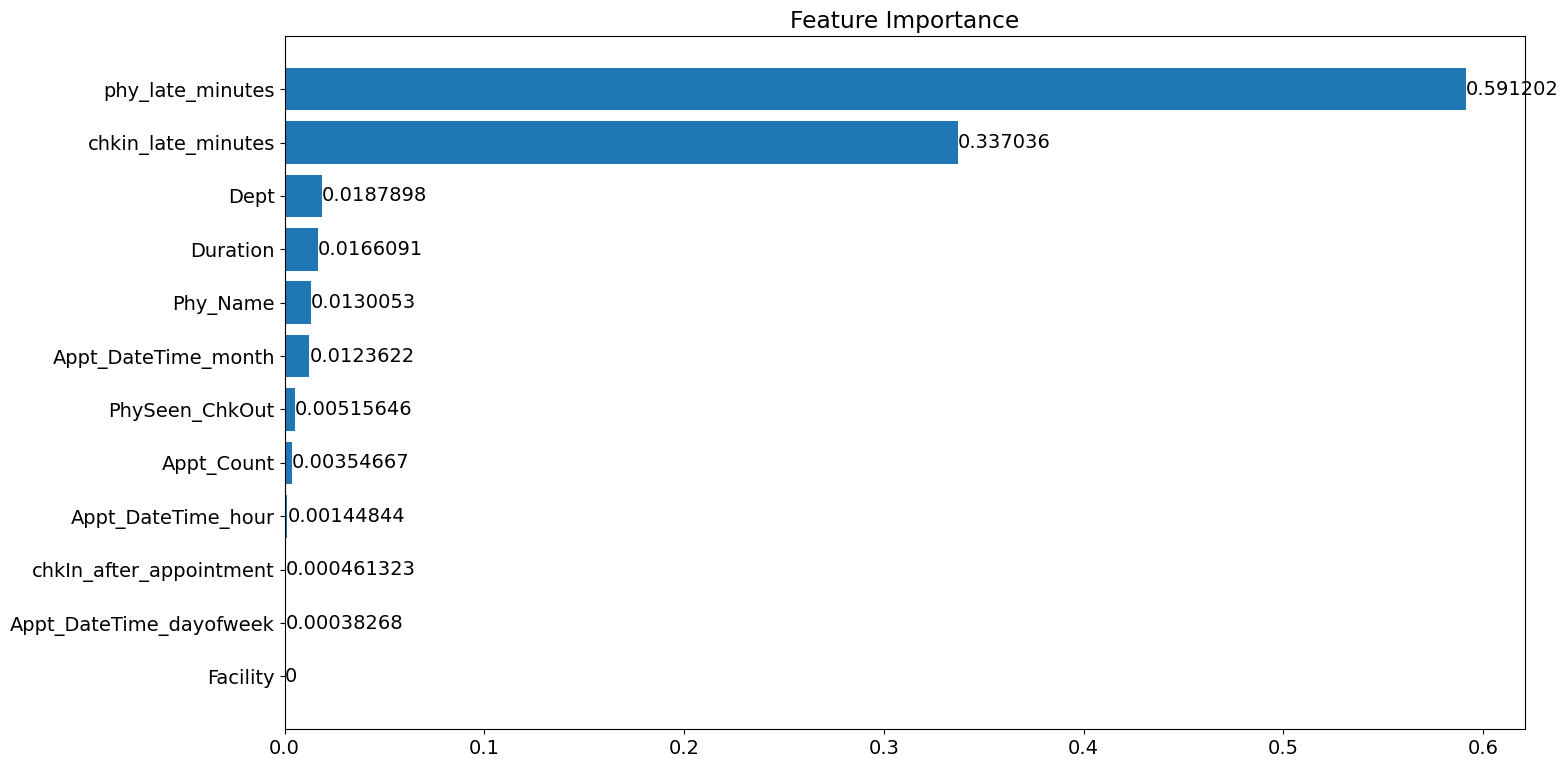

In [128]:
gbc, y_pred_gbc, y_score_gbc = classify(GradientBoostingClassifier(), x_train, y_train,x_test,y_test)
feature_gbc = feat_importance(gbc)

labels, values = zip(*feature_gbc)
fig, ax = plt.subplots(figsize =(16, 9))
plt.rcParams.update({'font.size': 14})
a = ax.barh(labels, values)
ax.invert_yaxis()  
ax.bar_label(a, label_type='edge')
ax.set_title('Feature Importance')

### Feature importance of XGBoosting

Accuracy:  0.753492777646223
Area under the ROC curve:  0.9417017257996714
matthews_corrcoef 0.6686622076030007
F-metric:  0.7490319619929224
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      2989
           1       0.69      0.69      0.69      2308
           2       0.85      0.63      0.72      1341
           3       0.85      0.65      0.74       785
           4       0.81      0.78      0.80      1023

    accuracy                           0.75      8446
   macro avg       0.79      0.72      0.75      8446
weighted avg       0.76      0.75      0.75      8446

 
Evaluation by cross-validation:
[0.7623034  0.7412481  0.76325806 0.75412332 0.7688404 ]


Text(0.5, 1.0, 'Feature Importance')

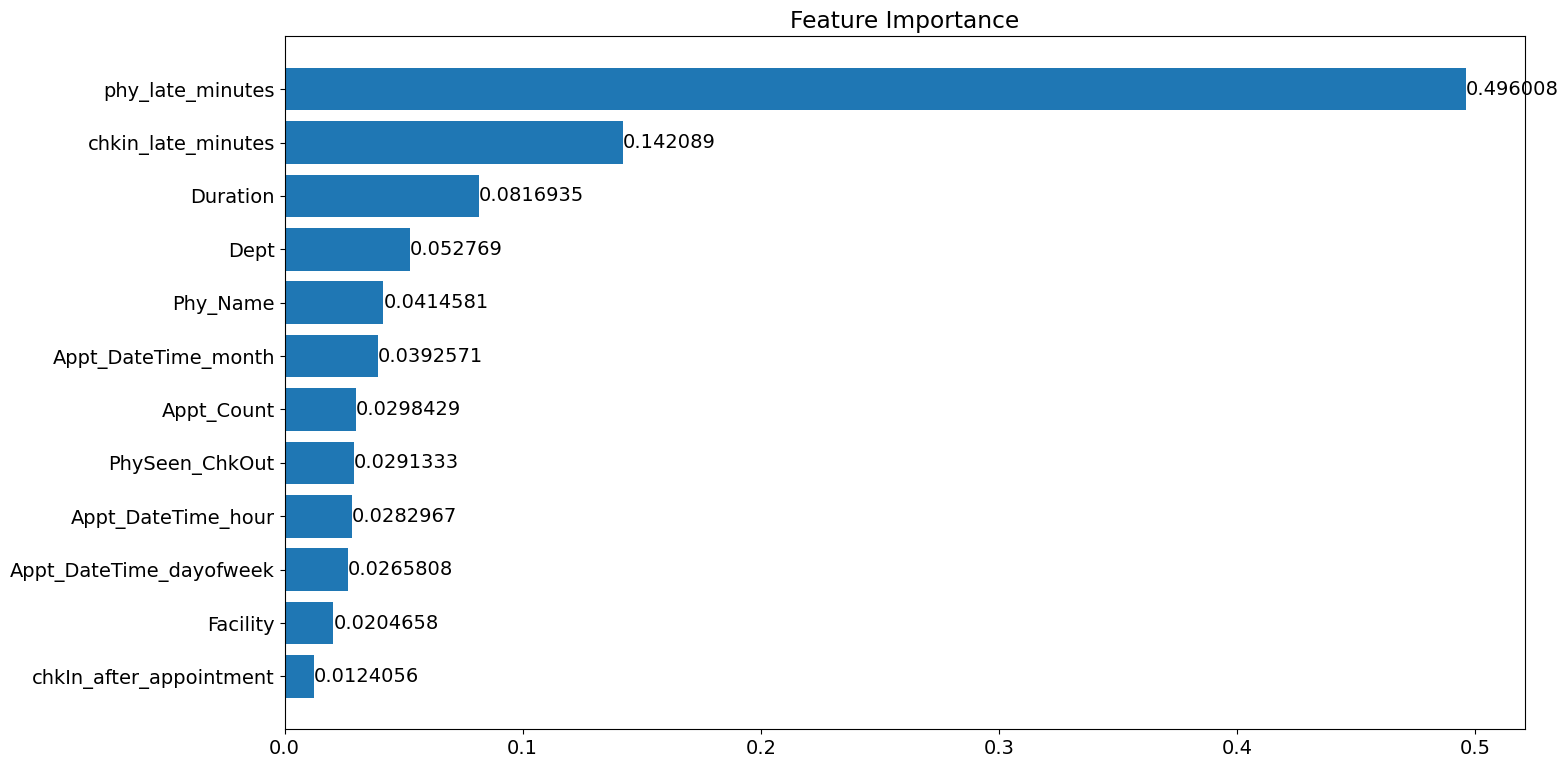

In [203]:
xgb, y_pred_xgb, y_score_xgb = classify(XGBClassifier(), x_train, y_train,x_test,y_test)

feature_xgb = feat_importance(xgb)
labels, values = zip(*feature_xgb)
fig, ax = plt.subplots(figsize =(16, 9))
plt.rcParams.update({'font.size': 14})
a = ax.barh(labels, values)
ax.invert_yaxis()  
ax.bar_label(a, label_type='edge')
ax.set_title('Feature Importance')

The precision score indicates that 76% of the time the model has effectively identified waiting time in the range of 0 to 15 minutes) and 67% has predicted correctly that the waiting time in the range of 16 to 30 minutes. Stacking models don't show how the models are chosen, so the contribution of each feature to the model is unkown. 